In [1]:
#IMPORTING NECESSARY PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import copy
import numpy as np
from scipy.io import arff

In [2]:
#READING DATA AND PREPROCESSING
data=arff.loadarff('diabetes1.arff')
dataset=pd.DataFrame(data[0])
dataset['class']=dataset['class'].apply(lambda x: x.decode("utf-8"))
train_data=copy.deepcopy(dataset.iloc[:,:8])
train_data=(train_data-train_data.mean())/train_data.std()
#FUNCTION TO APPLY PCA
def pca(X,num_components):
  cov_mat = np.cov(X , rowvar = False)
  eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalue = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:,sorted_index]
  eigenvector_subset = sorted_eigenvectors[:,0:num_components]
  X_reduced = np.dot(eigenvector_subset.transpose() , X.transpose()).transpose()
  return X_reduced
#APPLYING PCA
reduced_train_data=pca(train_data,2)
reduced_train_data=pd.DataFrame(reduced_train_data,columns=['x','y'])
#FUNCTION TO APPLY DBSCAN 
def dbscan(df,eps=1,minpts=5):
  rows=df.shape[0]
  cols=df.shape[1]
  cno=0
  df=df*(minpts+eps-1)
  df['cluster']=[cno for i in range(rows)]
  df['visited']=[False for i in range(rows)] # Initially none of the points are visited
  cno=cno+1
  for var in range(rows): #iterate for all the points 
    if df.loc[var,'visited']==False:
      queue=[] # queue storinf all the points for which number of points within radius 'eps' is greater than minpts
      temp_df=df[((df['x']-df.loc[var,'x'])**2+(df['y']-df.loc[var,'y'])**2)-eps**2<=0] 
      if len(temp_df)>=minpts : # Checking if number of points within radius 'eps' is greater than minpts
        for i in temp_df.index: # Iterate for all the points for which number of points within radius 'eps' is greater than minpts
          if df.loc[i,'visited']==False: # If the point is not visited
            df.loc[i,'visited']=True # visit the point 
            df.loc[i,'cluster']=cno # Assign the same cluster number for all such points
            queue.append(i) # append the points in the queue.
        while(len(queue)>0): # Iterate while the queue is not empty
          x=queue[0] # store the Front element of the queue 
          queue.pop(0) # Delete the front element 
          temp_df=df[((df['x']-df.loc[x,'x'])**2+(df['y']-df.loc[x,'y'])**2)-eps**2<=0]  
          if len(temp_df)>=minpts : # Checking if number of points within radius 'eps' is greater than minpts for the popped element
            for i in temp_df.index: # Iterate for all the points for which number of points within radius 'eps' is greater than minpts
              if df.loc[i,'visited']==False: # If the point is not visited
                  df.loc[i,'visited']=True # visit the point 
                  df.loc[i,'cluster']=cno # Assign the same cluster number for all such points
                  queue.append(i) # append the points in the queue.
      cno=cno+1 # change the cluster number
  return df

In [3]:
#STORING THE RESULT OF DBSCAN
test=dbscan(copy.deepcopy(reduced_train_data),2,5)

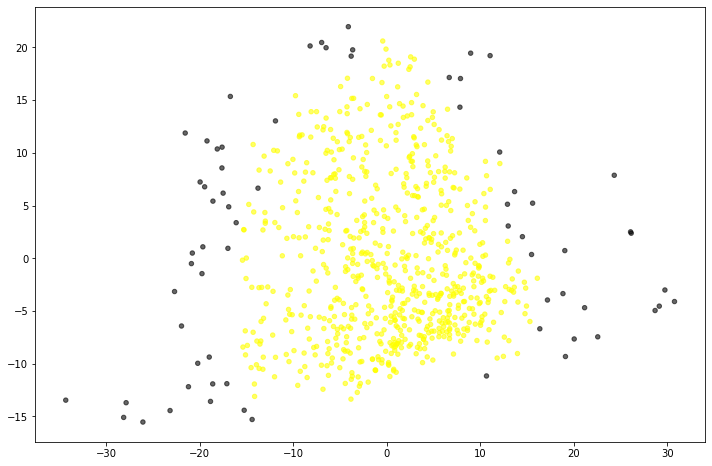

In [4]:
#PLOTTING THE CLUSTERS 
plt.figure(figsize=[12,8])
plt.scatter(test.iloc[:,0],test.iloc[:,1] ,c=test.cluster,cmap='gnuplot', alpha = 0.6, s=20)

In [5]:
#FINDING A CORE POINT AND ITS BORDER POINTS
index=np.random.randint(test.shape[0])
while(1):
  mask=(((test['x']-test.loc[index,'x'])**2+(test['y']-test.loc[index,'y'])**2)-4>=-0.2) & (((test['x']-test.loc[index,'x'])**2+(test['y']-test.loc[index,'y'])**2)-4<=0.2)
  core=test[mask].copy()
  if len(core)>=8:
    core.loc[len(core)]=[test.loc[index,'x'],test.loc[index,'y'],10,True]
    index=len(core)-1
    break
  else:
    index=np.random.randint(test.shape[0])
  
  
core.loc[:,'cluster']=11
core.loc[index,'cluster']=10

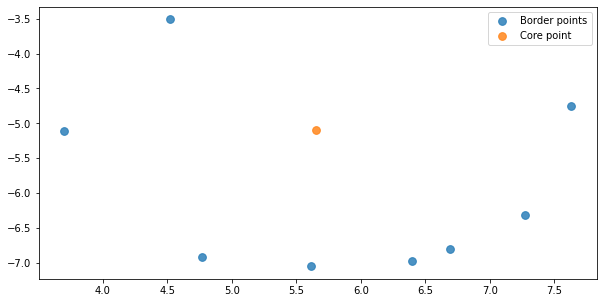

In [6]:
#PLOTTING THE CORE AND BORDER POINTS
plt.figure(figsize=[10,5])
plt.scatter(core[core['cluster']==11].iloc[:,0],core[core['cluster']==11].iloc[:,1] ,label='Border points' ,cmap='rainbow', alpha = 0.8, s=60)
plt.scatter(core[core['cluster']==10].iloc[:,0],core[core['cluster']==10].iloc[:,1] ,label='Core point' ,cmap='rainbow', alpha = 0.8, s=60)
plt.legend()